# Bridge Environment, only one way across the gap
## Attempt at learning changing environments without extra negative feedback

In [1]:
from hrr import *
from Agent import *
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [2]:
color_set = ["red", "green"]

hrr_size = 1024 # Dimensionality of the HRRs (minimum 10x maze_size)

# All now pre-assigned in Agent, but can be overwritten in constructor
policy_gamma = 0.9 # Delayed reward coefficient 
policy_alpha = 0.001 # Learning rate
policy_epsilon = 0.03 # Random action chance
policy_lambda = 0.1 # delta affector

epochs = 1000 
max_moves = 25

ltm = LTM(N=hrr_size, normalized=True, M=1)
suboptimal_steps = [] # performance tracker for 

choice_function = np.mean 

In [3]:
maze_red = ["Y", "Y", "G", "Y", "Y",
            "Y", "N", "N", "N", "N",
            "Y", "N", "N", "N", "N",
            "Y", "N", "N", "N", "N",
            "Y", "Y", "Y", "Y", "Y"]

maze_green = ["Y", "Y", "G", "Y", "Y",
              "N", "N", "N", "N", "Y",
              "N", "N", "N", "N", "Y",
              "N", "N", "N", "N", "Y",
              "Y", "Y", "Y", "Y", "Y"]

mazes = [maze_red, maze_green]

maze_size = 25
row_size = 5

In [4]:
actor = Agent(["left", "right", "up", "down"], 32, ltm)
i_gate = Agent(["open", "close"], 8, ltm)

In [5]:
for epoch in range(epochs):
    current_state = 19+np.random.choice(5)
    goal_idx = np.random.choice(range(len(color_set)))
    #optimal_steps = min((current_state-goal[goal_idx])%maze_size,  (goal[goal_idx]-current_state)%maze_size)
    current_signal = color_set[goal_idx]
    
    board = mazes[goal_idx]
    
    current_wm = "I"
    
    if(epoch+1) % 10 == 0:
        print('\rEpisode:', (epoch+1), end='')
        
    for step in range(max_moves):
        if board[current_state] == "G":
            break

        i_gate.policy(current_state, current_signal, current_wm)
        
        if i_gate.current_action == i_gate.action_set[0]:
            current_wm = current_signal
        
        actor.policy(current_state, current_signal, current_wm)
        
        prev_state = current_state
        
        if actor.current_action == actor.action_set[0]:
            current_state = current_state if current_state % row_size ==  0 else current_state - 1  
        elif actor.current_action == actor.action_set[1]:
            current_state = current_state if current_state+1 % row_size ==  0 else current_state + 1
        elif actor.current_action == actor.action_set[2]:
            temp = (current_state-row_size)
            current_state = temp if temp >= 0 else current_state
        elif actor.current_action == actor.action_set[3]:
            temp = (current_state+row_size)
            current_state = temp if temp <= maze_size else current_state
            
        current_state = prev_state if current_state >= maze_size or current_state <= 0 else current_state
            
        if board[current_state] == "N":
            current_state = prev_state

            
        is_goal = board[current_state] == "G"
            
        actor.update(current_state, current_signal, current_wm, is_goal)
        i_gate.update(current_state, current_signal, current_wm, is_goal)
            
        current_signal = "I"

    #suboptimal_steps.append(step - optimal_steps)

Episode: 1000

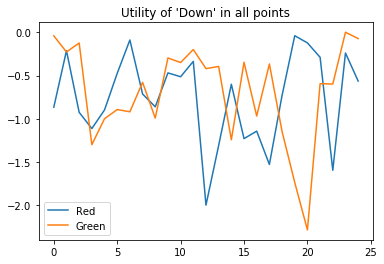

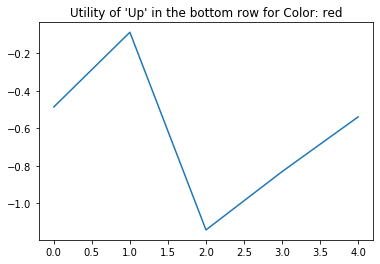

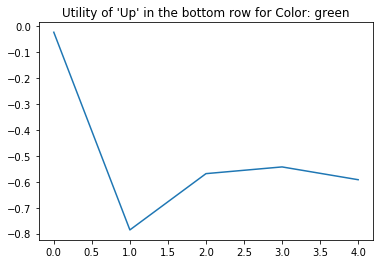

In [6]:
#data = []
#for action in actor.action_set:
#    for color in color_set:
#        data += [choice_function(actor.model.predict(actor.encode(state, action, color))+actor.bias) for state in range(maze_size)]
#data = np.reshape(data, [4,maze_size]).T
#plt.plot(data)
#plt.legend(["left red", "left green", "right red", "right green"])
#plt.show()

#window_size = 100
#data = [np.mean(suboptimal_steps[x:x+window_size]) for x in range(len(suboptimal_steps)-window_size)]
#plt.plot(data)
#plt.show()

data = []


for color in color_set:
    data += [choice_function(actor.model.predict(actor.encode(state, "down", color))+actor.bias) for state in range(maze_size)]
    
data = np.reshape(data, [2,maze_size]).T
    
plt.plot(data)
plt.title("Utility of 'Down' in all points")
plt.legend(["Red", "Green"])
plt.show()

for color in color_set:
    data = []
    data += [choice_function(actor.model.predict(actor.encode(state, "up", color))+actor.bias) for state in range(19,maze_size-1)]
    plt.plot(data)
    plt.title("Utility of 'Up' in the bottom row for Color: " + color)
    plt.show()